## Brain tumor Classification - ResNet50 architecture

## Introduction
  A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 12,000 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.
  
  
## Objective
According to the World Health Organization (WHO), proper brain tumor diagnosis involves detection, brain tumor location identification, and classification of the tumor on the basis of malignancy, grade, and type.


Based on the convolutional neural network (CN), we can help doctors identify a brain tumor based on the results of Magnetic Resonance Imaging (MRI).


## Dataset
The type of tumor is determined by the cells forming it (histological classification).The most common types of brain cancer - 4 classes:

1. Not tumor: indicates that those images do not contain a tumor.
2. Meningioma: is a type of tumor that develops from the membranes that surround the brain and spinal cord.
3. Glioma: is a type of tumor that develops from glial cells, which are cells that support and protect neurons.
4. Pituitary tumor: is a type of tumor that develops from the pituitary gland, which is located at the base of the brain.

### Step№1: Import libraries

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from keras.applications import VGG16, Xception
from tensorflow.keras.layers import (Input, 
                                     Add, 
                                     Dense, 
                                     Activation, 
                                     BatchNormalization, 
                                     Flatten, 
                                     Conv2D, 
                                     AveragePooling2D, 
                                     MaxPooling2D, 
                                     GlobalAveragePooling2D,
                                     Dropout)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.callbacks import (ReduceLROnPlateau, 
                                        EarlyStopping, 
                                        ModelCheckpoint, 
                                        LearningRateScheduler)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Visualizing plot of train and validation loss &  accuracy
def plot_history_acc_loss(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    
    sns.despine()
    ax[0].plot(epochs, train_acc, color= 'red',
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, color= 'green',
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, color='red',
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, color='green',
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

### Step№2: Importing dataset

In [1]:
Brain_directory = ('../archive/Training/')
test_directory = ('../archive/Testing/')

In [4]:
classes = os.listdir(Brain_directory)
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [5]:
for idx, name in enumerate(classes):
    print(f"{idx} = {name}", end=", ")

0 = glioma_tumor, 1 = meningioma_tumor, 2 = no_tumor, 3 = pituitary_tumor, 

### Step№3 Data Augmentation

In [6]:
#resize images and convert to numpy.
IMAGE = []
LABELS = []
image_size = 256
for label in classes:
    path_train = os.path.join(Brain_directory, label)
    for j in os.listdir(path_train):
        img = cv2.imread(os.path.join(path_train, j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
            
        
for label in classes:
    path_test = os.path.join(test_directory, label)
    for j in os.listdir(path_test):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        IMAGE.append(img)
        LABELS.append(label)
        
X = np.array(IMAGE)
y = np.array(LABELS)

In [8]:
classes_info = {}
classes = sorted(os.listdir(Brain_directory))
for name in classes:
    classes_info[name] = len(os.listdir(Brain_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title= 'Training dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()


{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}


In the training dataset: 
   
     3 = pituitary_tumor 827(28.8%). 
     0 = glioma_tumor 826(28.8%), 
     1 = meningioma_tumor 822(28.6%), 
     2 = no_tumor 395(13.8%), 
   

In [9]:
classes_info = {}
classes = sorted(os.listdir(test_directory))
for name in classes:
    classes_info[name] = len(os.listdir(test_directory + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='Testing dataset')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


In the testing dataset:
 
       1 = meningioma_tumor 115(29.2%), 
       2 = no_tumor 105(26.6%),
       0 = glioma_tumor 100(25.4%), 
       3 = pituitary_tumor 74(18.8%)

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((2611, 256, 256, 3), (653, 256, 256, 3))

### to_categorical

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Step№4 Data Generator

In [12]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [13]:
train_generator = image_generator.flow_from_directory(
    batch_size = 40,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'training'
)

Found 2297 images belonging to 4 classes.


In [14]:
validation_generator = image_generator.flow_from_directory(
    batch_size = 40, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 573 images belonging to 4 classes.


In [15]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(
    batch_size = 4, 
    directory = test_directory, 
    shuffle = True, 
    target_size = (256, 256), 
    class_mode = 'categorical'
)

Found 394 images belonging to 4 classes.


In [16]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [17]:
train_images, train_labels = next(train_generator)
train_images.shape

(40, 256, 256, 3)

### Step№5 Showing images

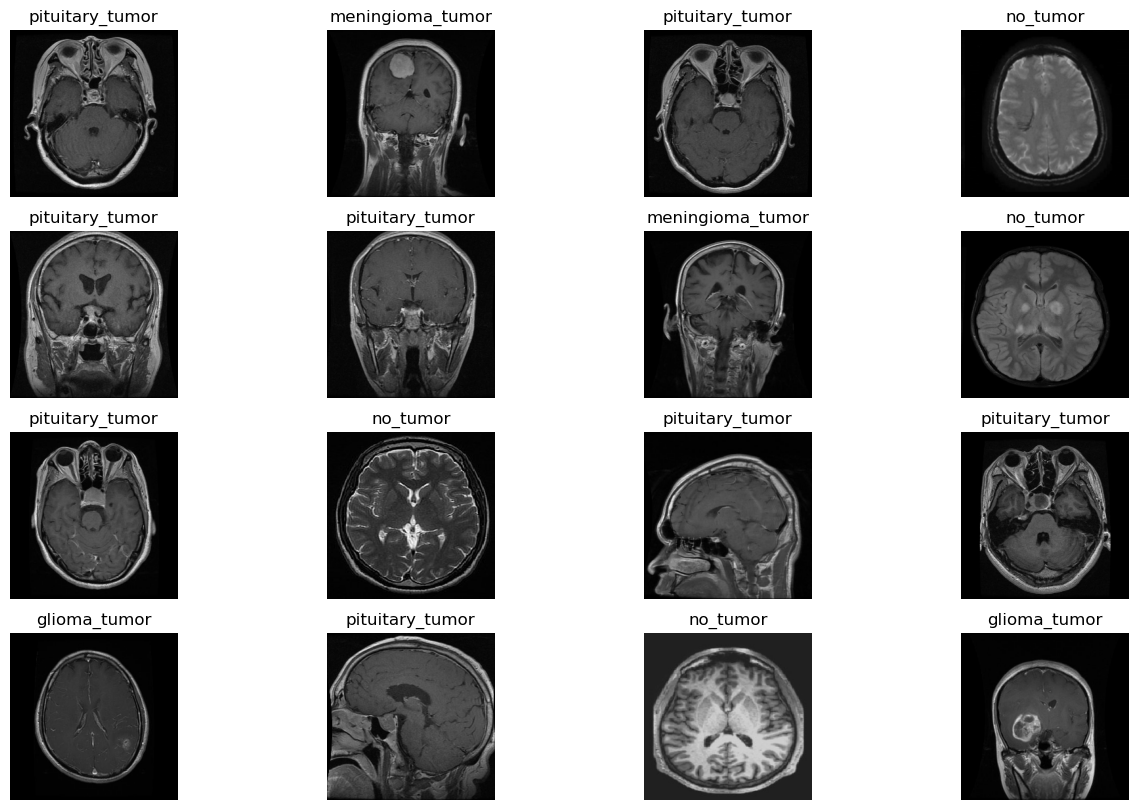

In [18]:
L = 4 
W = 4

fig, axes = plt.subplots(L, W, figsize = (15, 10))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(classes[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

### I. Step№6 Transfer learning - ResNet50 

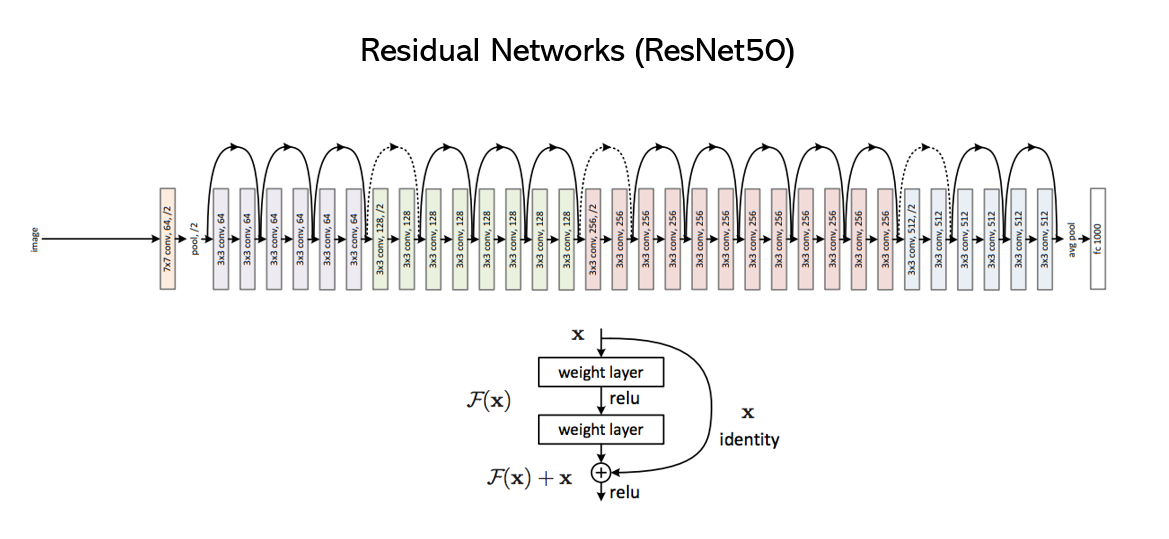 
ResNet 50 is a 50-layer Residual Network with 26M parameters. The residual network is a deep
convolutional neural network model that is introduced by Microsoft in 2015. In Residual network
rather than learning features, we learn from residuals that are subtraction of features learned from
the layer’s inputs. ResNet used the skip connection to propagate information across layers. ResNet
connects nth layer input directly to some (n+x)th layer which enables additional layers to be stacked
and a to establish a deep network.






In [19]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath= 'brainweights.hdf5', verbose = 1, save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,patience = 2, mode = 'auto', min_lr = 1e-15)
                             

In [20]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [21]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [22]:
for layer in basemodel.layers[:-20]:
    layer.trainable = False

In [23]:
train_generator = image_generator.flow_from_directory(
    batch_size = 4,
    directory = Brain_directory,
    shuffle = True, 
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = image_generator.flow_from_directory(
    batch_size = 4, 
    directory = Brain_directory,
    shuffle = True, 
    target_size = (256, 256),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [24]:
y_test

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### Step№7 Train model

In [25]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


model_1 = Model(inputs = basemodel.input, outputs = headmodel) 

In [26]:
model_1.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [27]:
history = model_1.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.7817
Epoch 1: val_loss improved from inf to 12.25069, saving model to brainweights.hdf5
82/82 [==============================] - 16s 97ms/step - loss: 0.6251 - accuracy: 0.7817 - val_loss: 12.2507 - val_accuracy: 0.5544
Epoch 2/50
81/82 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8877
Epoch 2: val_loss improved from 12.25069 to 1.12087, saving model to brainweights.hdf5
82/82 [==============================] - 7s 89ms/step - loss: 0.3028 - accuracy: 0.8878 - val_loss: 1.1209 - val_accuracy: 0.7917
Epoch 3/50
81/82 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.9398
Epoch 3: val_loss did not improve from 1.12087
82/82 [==============================] - 7s 84ms/step - loss: 0.1864 - accuracy: 0.9391 - val_loss: 1.2151 - val_accuracy: 0.8392
Epoch 4/50
81/82 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9533
Epoch 4: val_lo

C:\Users\User\AppData\Local\Temp\ipykernel_3260\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



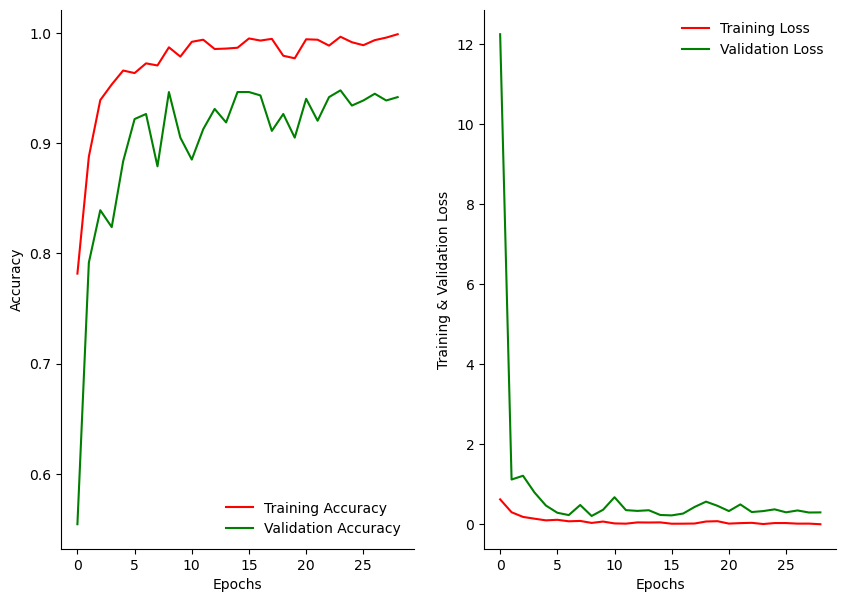

In [28]:
plot_history_acc_loss(history)

### Step№8 Evaluate Model with Test Samples, classification_report, confusion_matrix

In [29]:
evaluate = model_1.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 1s 58ms/step - loss: 0.2995 - accuracy: 0.9418
Testing accuracy : 0.9418070316314697
Testing loss: 0.2995416522026062


In [30]:
test_predictions = model_1.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 74ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       181
           1       0.90      0.95      0.92       200
           2       1.00      0.93      0.96        95
           3       0.97      0.99      0.98       177

    accuracy                           0.94       653
   macro avg       0.95      0.94      0.94       653
weighted avg       0.94      0.94      0.94       653



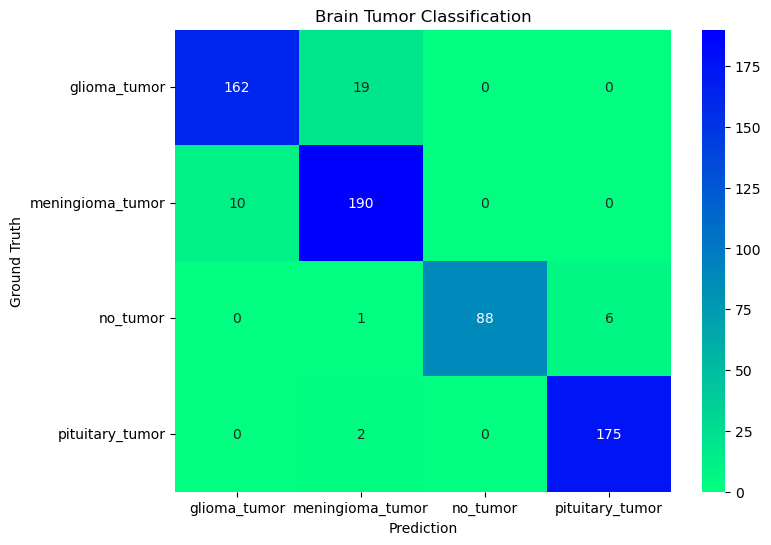

In [31]:
cm = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, cmap='winter_r', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

    1. with one layer, the model shows a normal result: training 99%, test 94%.

### Step№9 Visualizing Model Predictions 

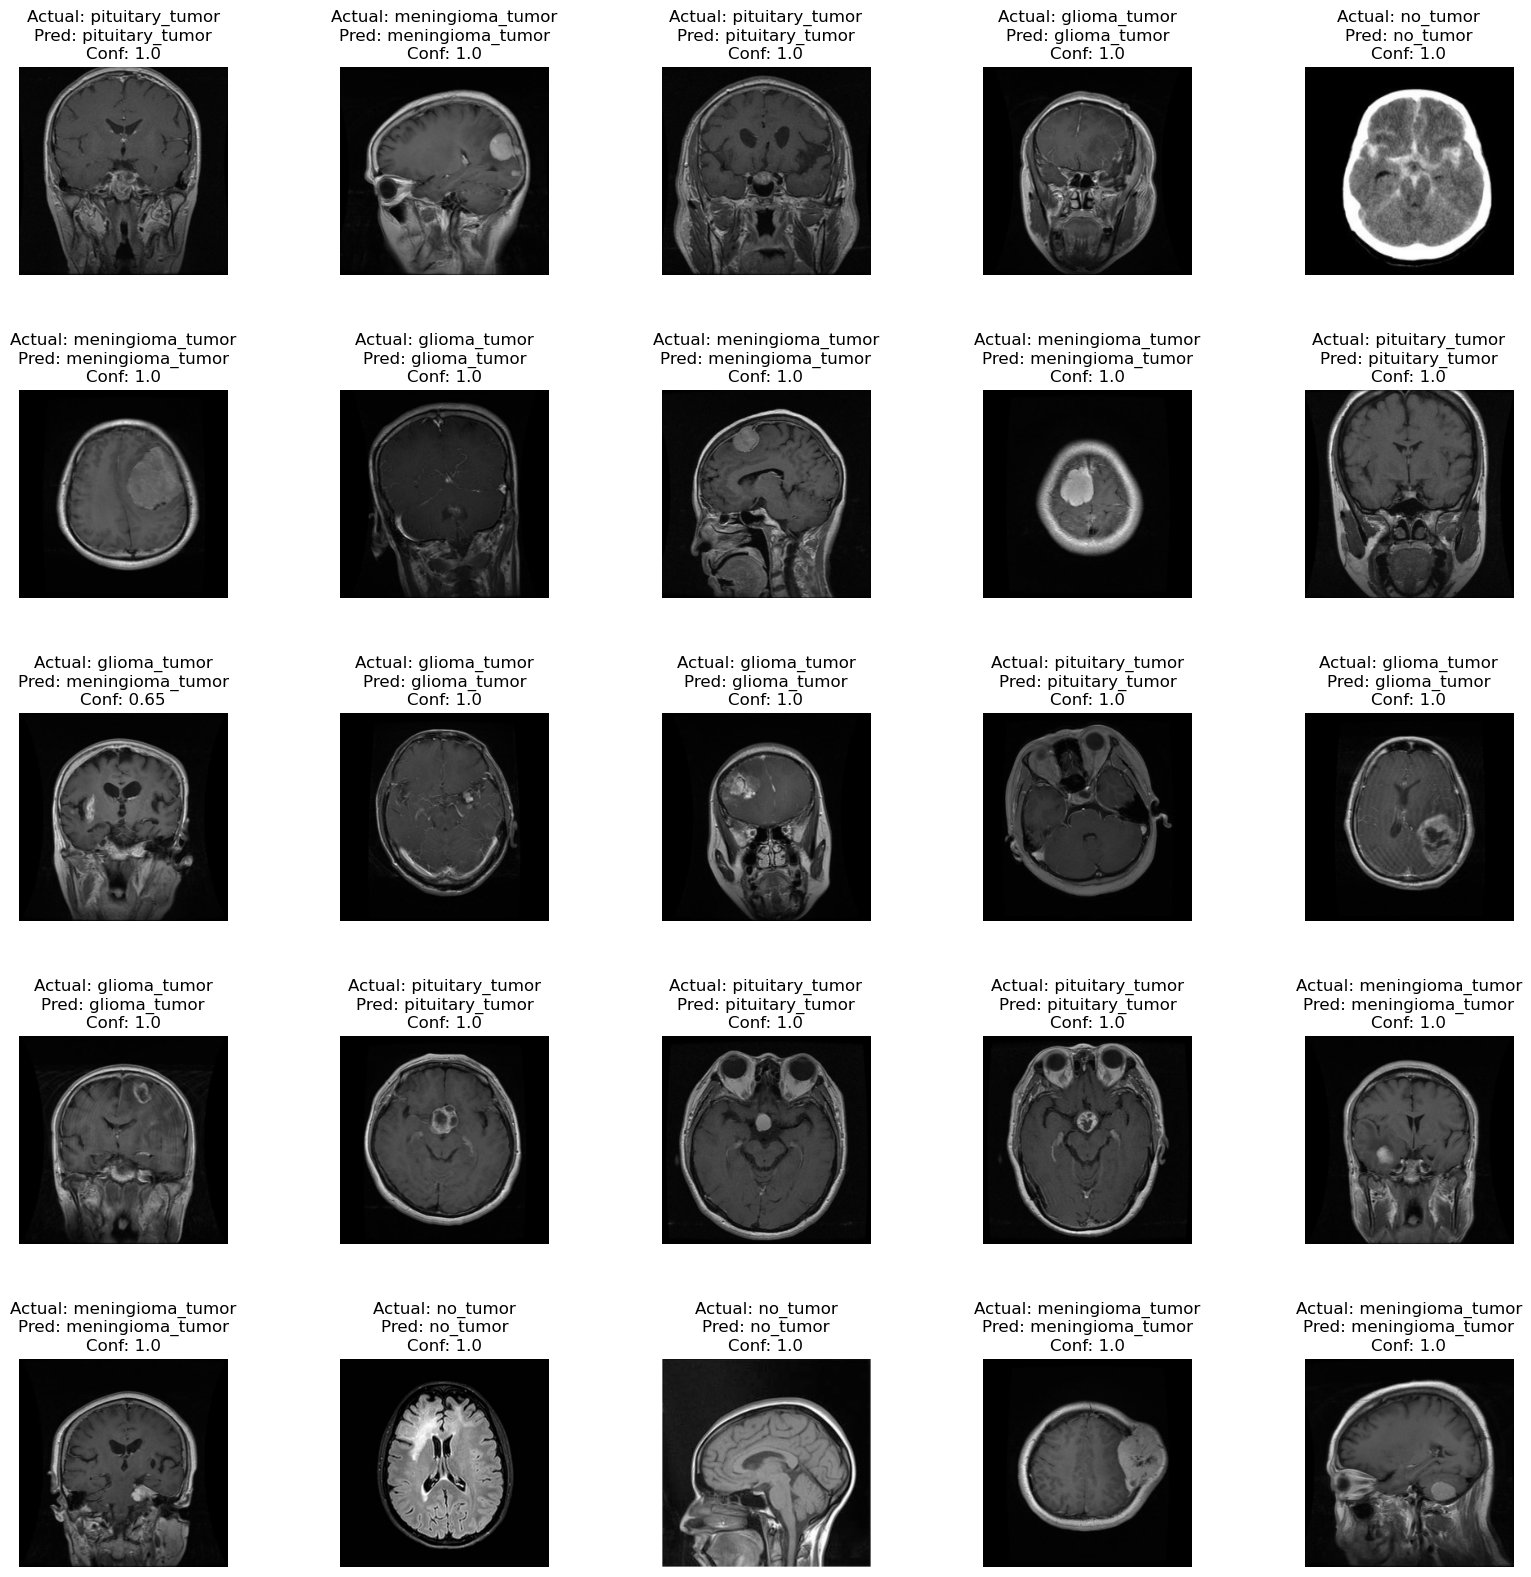

In [32]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   

    model ResNet50 with one hidden layer shows normal results, but confuses glioma with meningioma, gives 0.65%, in other cases 100%. 
    
    I am confident that the Resnet50 model can show better results and I adjust my model with the addition of another hidden layer. 

## II. Two Dense layers

In [33]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))


for layer in basemodel.layers[:-20]:
    layer.trainable = False

In [36]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


model_1 = Model(inputs = basemodel.input, outputs = headmodel)

In [37]:
model_1.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-3), metrics= ['accuracy'])

In [38]:
history = model_1.fit(X_train, y_train,
    epochs = 50, 
    validation_data = (X_test, y_test), 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/50
81/82 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.7762
Epoch 1: val_loss did not improve from 0.20975
82/82 [==============================] - 9s 92ms/step - loss: 0.6280 - accuracy: 0.7763 - val_loss: 2.4544 - val_accuracy: 0.7887
Epoch 2/50
81/82 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8900
Epoch 2: val_loss did not improve from 0.20975
82/82 [==============================] - 7s 85ms/step - loss: 0.3192 - accuracy: 0.8893 - val_loss: 1.2813 - val_accuracy: 0.8515
Epoch 3/50
81/82 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9090
Epoch 3: val_loss did not improve from 0.20975
82/82 [==============================] - 7s 85ms/step - loss: 0.2546 - accuracy: 0.9088 - val_loss: 1.4951 - val_accuracy: 0.8025
Epoch 4/50
81/82 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9263
Epoch 4: val_loss did not improve from 0.20975
82/82 [==============================] - 7s 85

Epoch 31/50
81/82 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9954
Epoch 31: val_loss did not improve from 0.15373
82/82 [==============================] - 7s 84ms/step - loss: 0.0200 - accuracy: 0.9954 - val_loss: 0.2985 - val_accuracy: 0.9418
Epoch 32/50
81/82 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9950
Epoch 32: val_loss did not improve from 0.15373
82/82 [==============================] - 7s 84ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.3791 - val_accuracy: 0.9464
Epoch 33/50
81/82 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9927
Epoch 33: val_loss did not improve from 0.15373
82/82 [==============================] - 7s 84ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.1918 - val_accuracy: 0.9541
Epoch 34/50
81/82 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9965
Epoch 34: val_loss did not improve from 0.15373
82/82 [==============================]

C:\Users\User\AppData\Local\Temp\ipykernel_3260\178661625.py:29: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



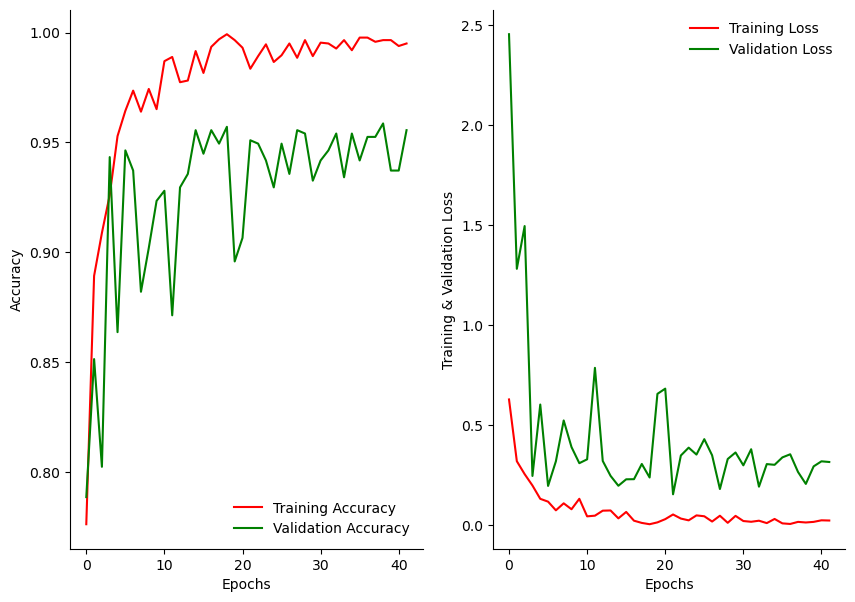

In [39]:
plot_history_acc_loss(history)

In [40]:
evaluate = model_1.evaluate(X_test, y_test)
print('Testing accuracy : {}'.format(evaluate[1])) 
print('Testing loss: {}'.format(evaluate[0]))

21/21 [==============================] - 2s 58ms/step - loss: 0.3152 - accuracy: 0.9556
Testing accuracy : 0.9555895924568176
Testing loss: 0.3152371048927307


In [41]:
test_predictions = model_1.predict(X_test)
pred = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, pred))

21/21 [==============================] - 2s 64ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       181
           1       0.90      0.97      0.93       200
           2       0.99      0.99      0.99        95
           3       1.00      0.97      0.99       177

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



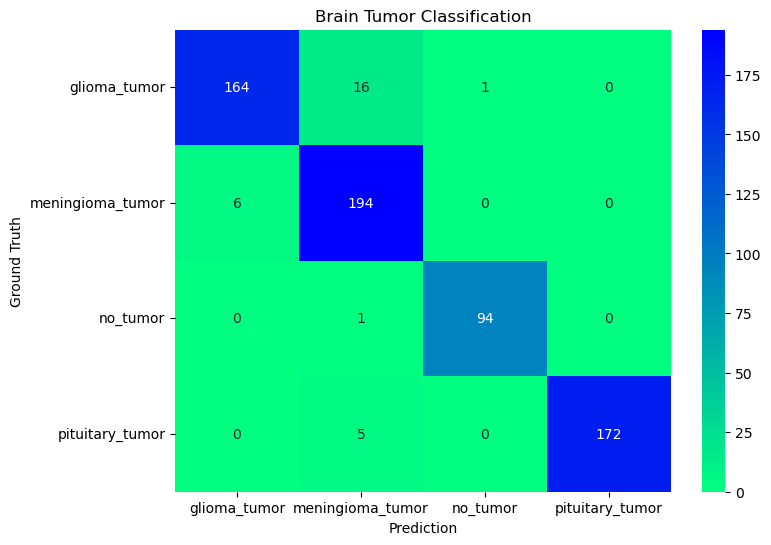

In [42]:
cm = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, cmap='winter_r', annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

After adding two layers, the model shows the best results: training 99%, test 96%.

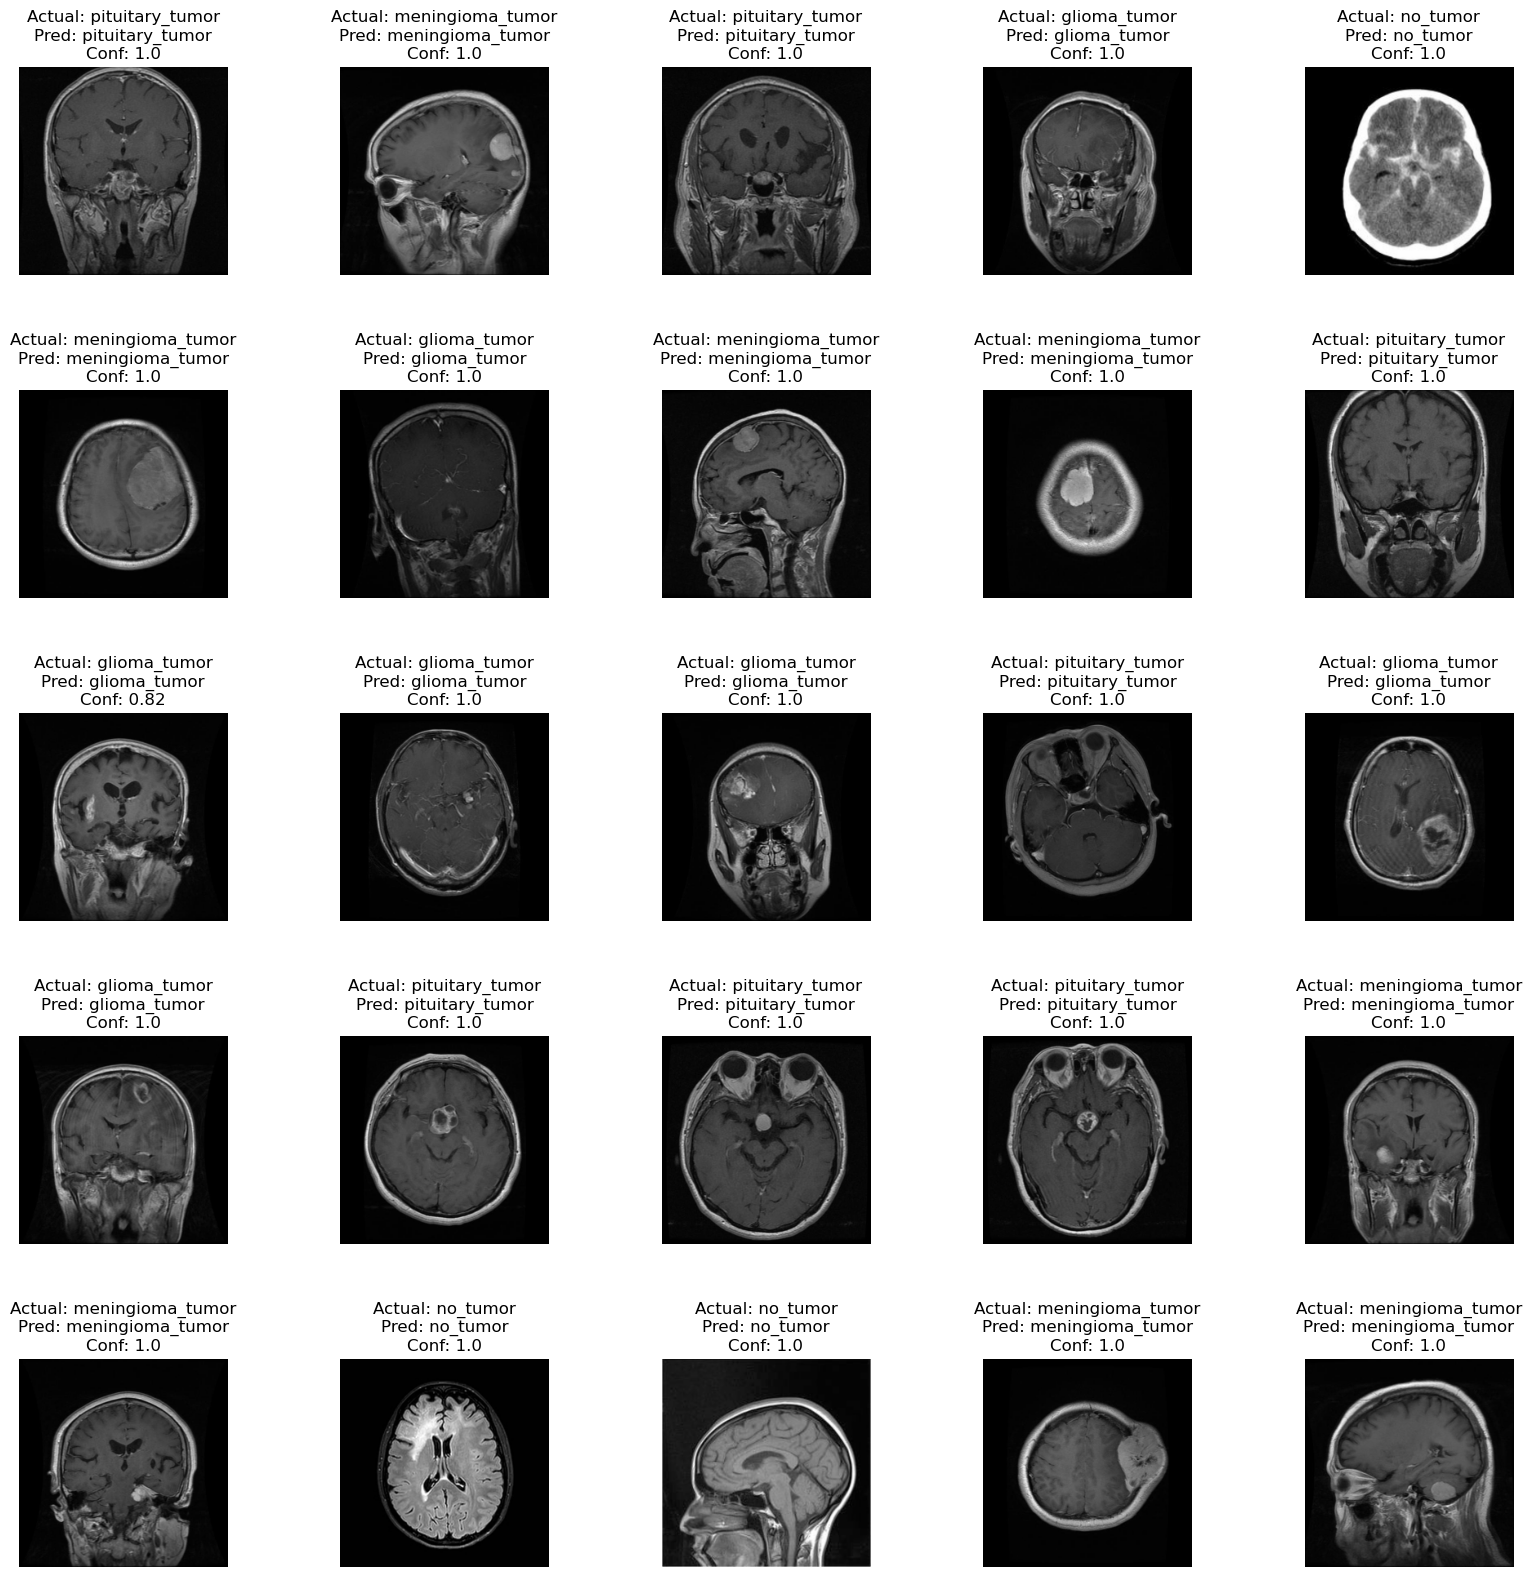

In [43]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = pred[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+classes[actual]+'\nPred: '+classes[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  

    Resnet50 model with two hidden layers shows better and stable results . No errors. 

### Conclusion

    In this project, I use ResNet50 model architecture with pre-trained weights on a popular ImageNet dataset to detect brain tumor (meningioma, glioma, pituitary tumor, no tumor) from MRI images . 

    I unfroze the last 20 layers of ResNet50 and searched for optimal hyperparameters. 

    ResNet50 model shows the best and stable results.
    The results are above 90%.  But with one hidden layer the model confuses glioma with meningioma, gives 0.65%, in other cases 100%. 
    Best performance was given with two hidden layers. accuracy training 99%, test 96% and no errors. 

    The best hyperparameters for transfer learning on ResNet50 in our project were:

         2 dense layers.
         GlobalAveragePooling2D
         Adam optimizer
        callbacks: early stopping and reduced learning rate
        dropout, flatten 